In [103]:
import pandas as pd
import numpy as np
import os
import sys
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base2018'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
DAMPING = 0.75
observed_auto_ownership = pd.read_csv(os.path.join(CENSUS_SUMMARY_PATH, "autoOwnershipCensus_2021.csv"))
model_hh = pd.read_csv(os.path.join(ASIM_OUTPUT, 'final_households.csv'))

coefficients = pd.read_csv(os.path.join(ASIM_CONFIGS_PATH, 'auto_ownership_coefficients.csv'))

In [104]:
mod = model_hh.groupby(['home_county', 'auto_ownership']).agg(model_pct = ('household_id', 'count')) / model_hh.groupby(['home_county']).agg(model_pct = ('household_id', 'count'))

modt = (model_hh.groupby('auto_ownership').agg(model_pct = ('household_id', 'count')) / model_hh.shape[0]).assign(home_county = 'Total').reset_index().set_index(['home_county', 'auto_ownership'])

mod = pd.concat([mod, modt])
mod_total = model_hh.groupby('auto_ownership').agg(model_pct = ('household_id', 'count')) / model_hh['household_id'].count()

In [105]:
obs = observed_auto_ownership.rename(columns = {'COUNTY': 'home_county', 'HHVEH': 'auto_ownership'}).groupby(['home_county', 'auto_ownership']).agg(census_pct = ('freq', 'sum')) / observed_auto_ownership.rename(columns = {'COUNTY': 'home_county', 'HHVEH': 'auto_ownership'}).groupby(['home_county']).agg(census_pct = ('freq', 'sum'))
obs_total = observed_auto_ownership.rename(columns = {'COUNTY': 'home_county', 'HHVEH': 'auto_ownership'}).groupby('auto_ownership').agg(census_pct = ('freq', 'sum')) / observed_auto_ownership['freq'].sum()

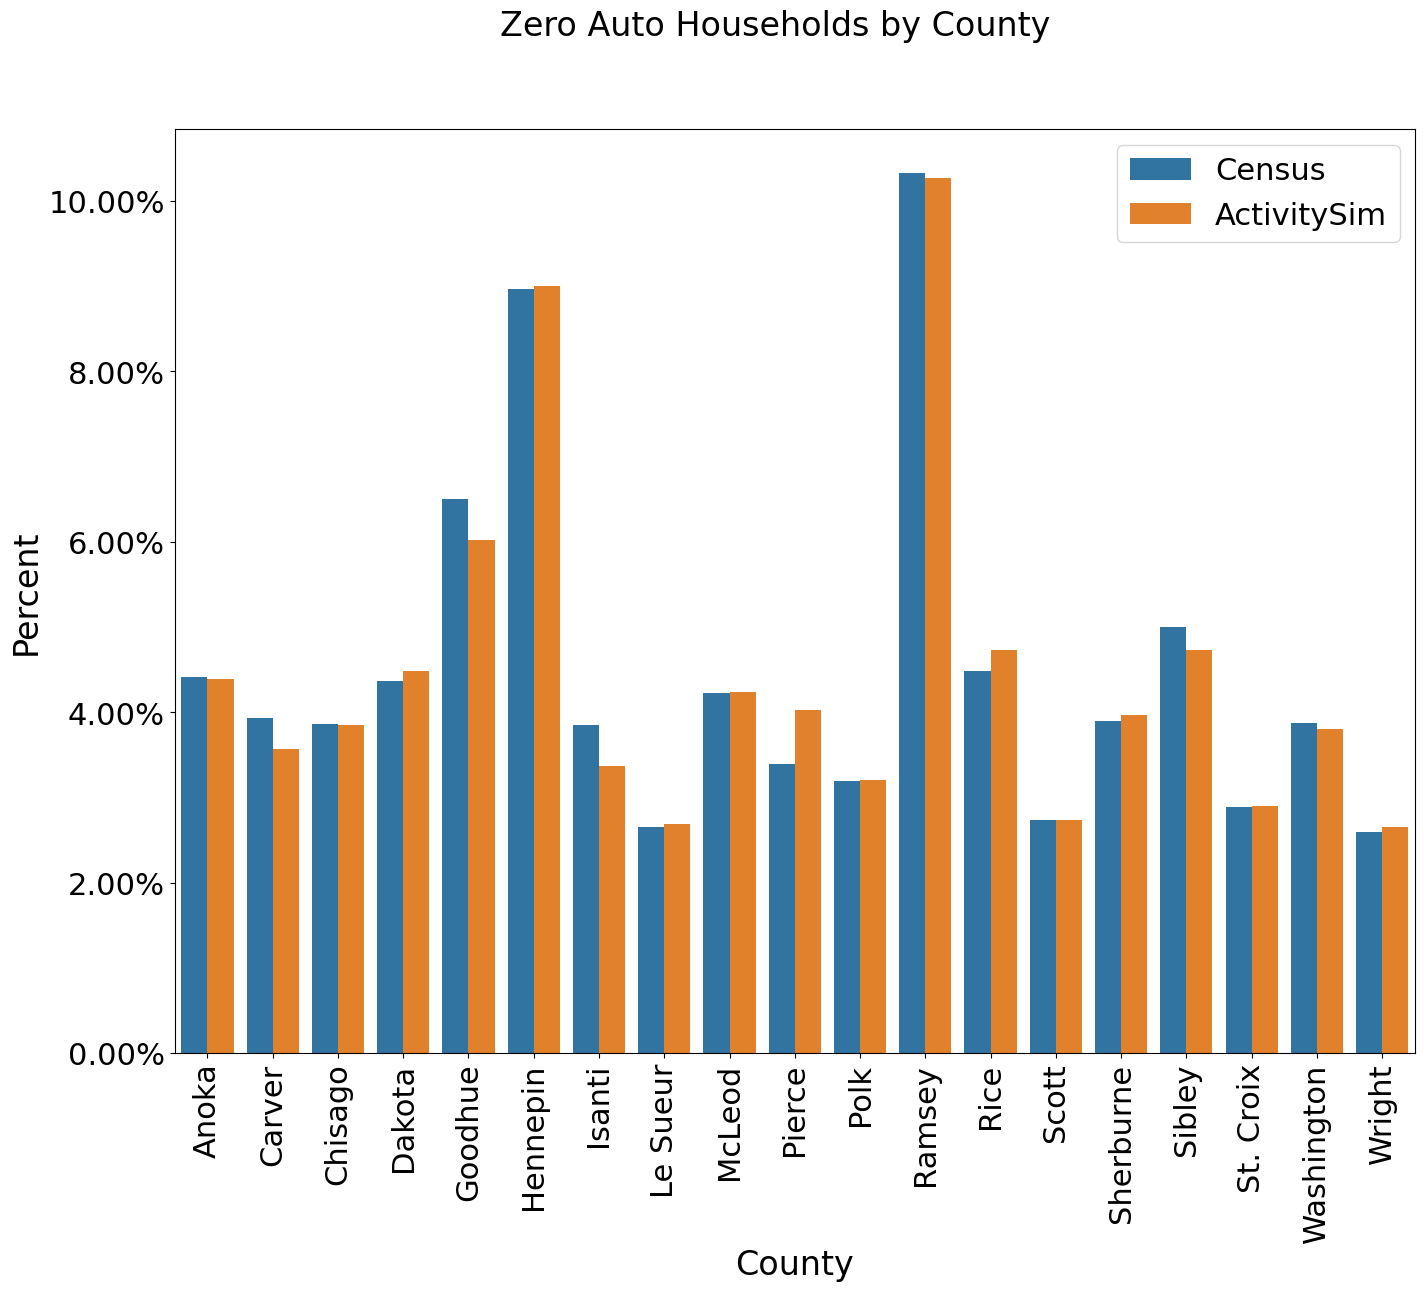

In [106]:
pd1 = obs.join(mod).reset_index().melt(id_vars = ['home_county', 'auto_ownership'], value_vars = ['census_pct', 'model_pct'])
plot_data = pd1[pd1['auto_ownership'] == 0]
plot_data.loc[plot_data['variable'] == 'census_pct', 'variable'] = 'Census'
plot_data.loc[plot_data['variable'] == 'model_pct', 'variable'] = 'ActivitySim'

fig, ax = plt.subplots(figsize=(16, 12))
fig.suptitle(f"Zero Auto Households by County", fontsize=24)
sns.barplot(data=plot_data, x='home_county', y='value', hue='variable')
plt.legend(fontsize=22)
plt.xticks(rotation=90, fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Percent', fontsize=24)
plt.xlabel('County', fontsize=24)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.2%}'))

In [107]:
zero_auto_county = obs.join(mod).query("auto_ownership == 0").fillna(0) #.reset_index().melt(id_vars = 'home_county', value_vars = ['census_pct', 'model_pct'])
zero_auto_county['coef_name'] = "coef_cars0_" + zero_auto_county.index.get_level_values(0).str.lower().str.replace("[\s,\.]","", regex = True) #.str.replace(".","")

zero_auto_county = zero_auto_county.merge(coefficients, how = 'left', left_on = 'coef_name', right_on = 'coefficient_name').rename(columns = {'value': 'input_value'})
zero_auto_county['value'] = zero_auto_county.apply(lambda x: x.input_value + np.log(x.census_pct / x.model_pct) * DAMPING if x.constrain == 'F' else np.nan, axis = 1)
#np.log(compare_table['census_pct'] / compare_table['model_pct']) 
#.index
zero_auto_county

,census_pct,model_pct,coef_name,coefficient_name,input_value,constrain,value
0,0.044116,0.043949,coef_cars0_anoka,NaN,NaN,NaN,NaN
1,0.039332,0.035733,coef_cars0_carver,NaN,NaN,NaN,NaN
2,0.038609,0.038562,coef_cars0_chisago,coef_cars0_chisago,0.527291,F,0.528217
3,0.043690,0.044903,coef_cars0_dakota,coef_cars0_dakota,-0.197961,F,-0.218514
4,0.065066,0.060201,coef_cars0_goodhue,coef_cars0_goodhue,0.435187,F,0.493480
5,0.089718,0.089998,coef_cars0_hennepin,coef_cars0_hennepin,0.137627,F,0.135290
6,0.038567,0.033711,coef_cars0_isanti,NaN,NaN,NaN,NaN
7,0.026583,0.026932,coef_cars0_lesueur,coef_cars0_lesueur,0.197021,F,0.187262
8,0.042288,0.042439,coef_cars0_mcleod,coef_cars0_mcleod,-0.870186,F,-0.872847
9,0.033922,0.040225,coef_cars0_pierce,NaN,NaN,NaN,NaN


In [108]:
zero_auto_county[zero_auto_county['coefficient_name'].str.len() > 0][['coefficient_name', 'value', 'constrain']].to_csv(sys.stdout, index = False)

coefficient_name,value,constrain
coef_cars0_chisago,0.528216988866693,F
coef_cars0_dakota,-0.2185139751088416,F
coef_cars0_goodhue,0.49348020742556215,F
coef_cars0_hennepin,0.13528955238828802,F
coef_cars0_lesueur,0.18726226679894442,F
coef_cars0_mcleod,-0.8728467263104377,F
coef_cars0_polk,-0.6030947979853004,F
coef_cars0_ramsey,0.2266613321598347,F
coef_cars0_rice,-0.5466717577878384,F
coef_cars0_scott,-0.3765483705828597,F
coef_cars0_sibley,0.18499440212913193,F
coef_cars0_stcroix,-0.5283847633053554,F
coef_cars0_washington,-0.15823227432448694,F
coef_cars0_wright,-0.49567084013254986,F


# One-Auto

Hennepin and Ramsey only

In [109]:
one_auto_county = obs.join(mod).query("auto_ownership == 1").fillna(0) #.reset_index().melt(id_vars = 'home_county', value_vars = ['census_pct', 'model_pct'])
one_auto_county['coef_name'] = "coef_cars1_" + one_auto_county.index.get_level_values(0).str.lower().str.replace("[\s,\.] ","", regex = True) #.str.replace(".","")

one_auto_county = one_auto_county.merge(coefficients, how = 'left', left_on = 'coef_name', right_on = 'coefficient_name').rename(columns = {'value': 'input_value'})
one_auto_county['value'] = one_auto_county.apply(lambda x: x.input_value + np.log(x.census_pct / x.model_pct) * DAMPING if x.constrain == 'F' else np.nan, axis = 1)
#np.log(compare_table['census_pct'] / compare_table['model_pct']) 
#.index
one_auto_county

,census_pct,model_pct,coef_name,coefficient_name,input_value,constrain,value
0,0.254347,0.263322,coef_cars1_anoka,NaN,NaN,NaN,NaN
1,0.217073,0.249097,coef_cars1_carver,NaN,NaN,NaN,NaN
2,0.196353,0.241542,coef_cars1_chisago,NaN,NaN,NaN,NaN
3,0.294346,0.274638,coef_cars1_dakota,NaN,NaN,NaN,NaN
4,0.276456,0.281966,coef_cars1_goodhue,NaN,NaN,NaN,NaN
5,0.357988,0.305108,coef_cars1_hennepin,NaN,NaN,NaN,NaN
6,0.244673,0.268116,coef_cars1_isanti,NaN,NaN,NaN,NaN
7,0.219715,0.275497,coef_cars1_le sueur,NaN,NaN,NaN,NaN
8,0.298002,0.318289,coef_cars1_mcleod,NaN,NaN,NaN,NaN
9,0.238335,0.270970,coef_cars1_pierce,NaN,NaN,NaN,NaN
